 # 模型解读

模型特点:
        
    1. 相比于lesnet更深了.
    2. 加入了relu作为激活层
    3. 使用了dropout,防止过拟合.
    4. 使用maxpooling,而不是averagepooling
    5. CNN在GPU上并行操作,加速训练

模型结构:

    输入图像size ： 227 * 227 * 3
    第一层卷积 ： 55*55*96 （相当于有96张55*55的图）
                并且，我们将这96张图，分成两部分，存在两个GPU上。（每部分都是55*55*48）
    池化： 27*27*96
    第二层卷积：  在每个GPU上，使用自己的48张图，生成 27*27*128的图。（所以总共是27*27*256）
    池化： 13*13×256

    第三层卷积：  在GPU1上，使用全部256份数据，生成上半部分的192的数据（13*13*192）。（总共是13*13*384）

    第四层卷积：  每个GPU各自将输入的13*13*192映射到13*13*192

    第五层卷积：  每个GPU 13*13*192-》13*13*128

    第六层池化：  每个GPU：6*6*128

    第六层全连接： 全部6*6*256进行全连接-》4096 （relu+drop）

    第七层全连接：4096->4096 （relu+drop）

    第八层全连接：4096->1000

    多GPU训练，通过精确控制feature map的传播来控制GPU间数据通信，仅有部分层需要利用全部的feature map。

# 读取数据

In [4]:
#　 AlexNet要求数据是227*227*3的，现在暂时没有下这个数据，只能建个模型看看

# 构建模型

In [45]:
from keras.models import Model
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Input,Dense,Flatten,Dropout
from keras.layers import BatchNormalization


In [47]:

inputs = Input(shape=(227,227,3))
# 卷积1
x = Conv2D(kernel_size=11,strides=4,filters=96,kernel_initializer='uniform',activation='relu')(inputs)
x = MaxPooling2D(pool_size=3,strides=2)(x)
x = BatchNormalization()(x)

# 卷积2
# 这里没有设置group=2的参数
x = Conv2D(padding='same',kernel_size=5,strides=1,filters=256,activation='relu',kernel_initializer='uniform')(x)
x = MaxPooling2D(pool_size=3,strides=2)(x)
x = BatchNormalization()(x)

# 卷积3
x = Conv2D(padding='same',kernel_size=3,strides=1,filters=384,activation='relu',kernel_initializer='uniform')(x)

# 卷积4
x = Conv2D(padding='same',kernel_size=3,strides=1,filters=384,activation='relu',kernel_initializer='uniform')(x)

# 卷积5
x = Conv2D(padding='same',kernel_size=3,strides=1,filters=256,activation='relu',kernel_initializer='uniform')(x)
x = MaxPooling2D(pool_size=3,strides=2)(x)


# 全连接6
x = Flatten()(x)
x = Dense(4096,activation='relu')(x)
x = Dropout(rate=0.5)(x)

# 全连接7
x = Dense(4096,activation='relu')(x)
x = Dropout(rate=0.5)(x)

# 全连接
x = Dense(1000,activation='softmax')(x)

model=Model(inputs=inputs,outputs=x)



batch_input_shape: (None, 227, 227, 3)


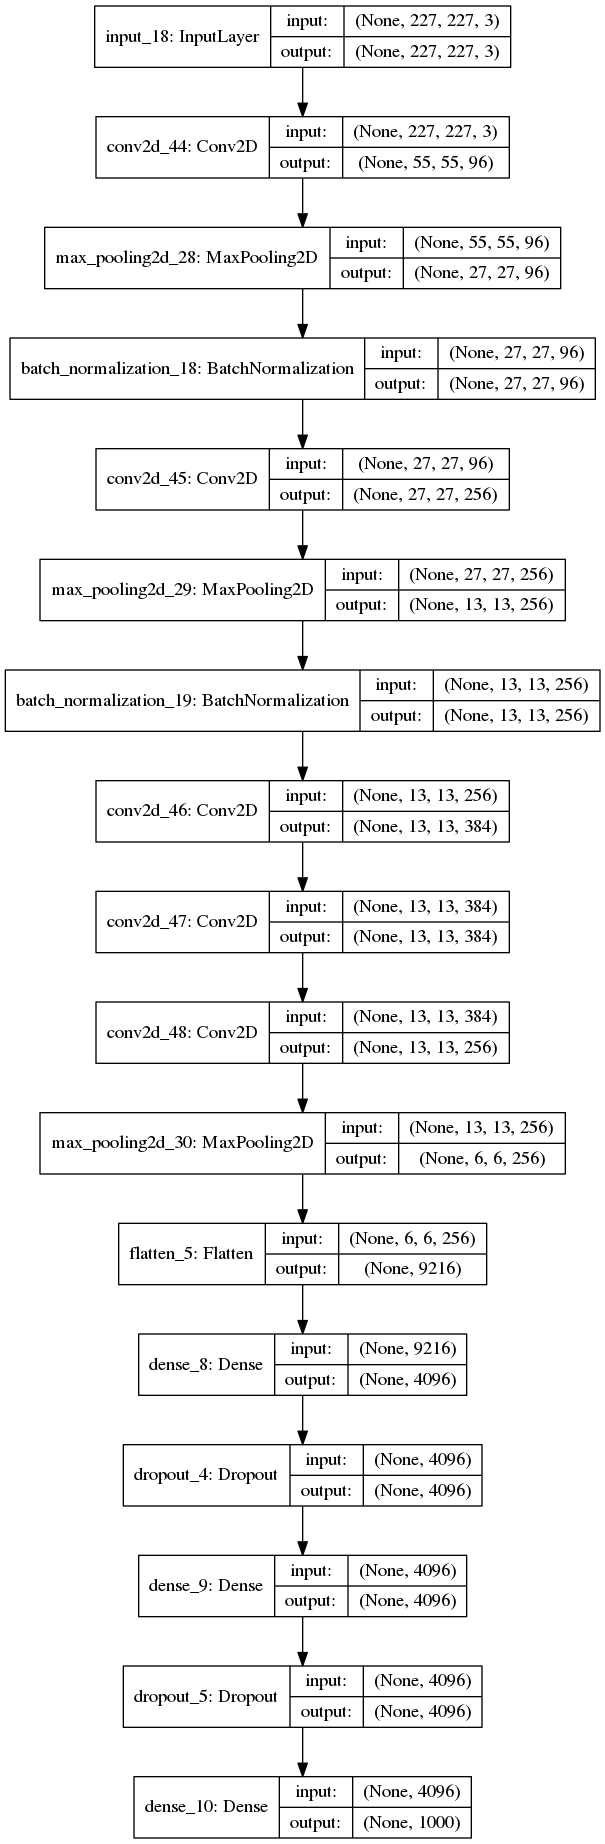

In [50]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

In [49]:
model.compile()
model.fit()

TypeError: compile() missing 1 required positional argument: 'optimizer'